In [1]:
import yfinance as yf
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

yf.pdr_override()

pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None)

In [6]:
def get_data(symbols):
    return get_stock_data(symbols).merge(get_covid_data(), left_index=True, right_index=True, how='outer')

def get_stock_data(symbols):
    return pdr.get_data_yahoo(symbols, start="2020-01-22",
                          end="2021-11-16")['Adj Close'][symbols]
    
def get_covid_data():
    df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
    covid_data = df[df['location']=='United States'][['date', 'total_cases', 'new_cases', 
                    'total_deaths', 'new_deaths', 'new_tests', 'total_tests',
                    'positive_rate', 'total_vaccinations', 'people_vaccinated']]
    covid_data.fillna(0, inplace=True)
    covid_data['date'] = covid_data['date'].astype('datetime64[ns]')
    covid_data.set_index('date', inplace=True)
    return covid_data[:665]


In [7]:
symbols = ['SPY', 
           'GOOG', 'TSLA', 'FB', 'AAPL', 'MSFT',
           'BTC-USD', 'ETH-USD', 'ADA-USD','XRP-USD', 'DOGE-USD', 
           'LTC-USD', 'XLM-USD', 'LINK-USD']

data = get_data(symbols)
features = list(data.columns)
np.array(features)

[*********************100%***********************]  14 of 14 completed


array(['SPY', 'GOOG', 'TSLA', 'FB', 'AAPL', 'MSFT', 'BTC-USD', 'ETH-USD',
       'ADA-USD', 'XRP-USD', 'DOGE-USD', 'LTC-USD', 'XLM-USD', 'LINK-USD',
       'total_cases', 'new_cases', 'total_deaths', 'new_deaths',
       'new_tests', 'total_tests', 'positive_rate', 'total_vaccinations',
       'people_vaccinated'], dtype='<U18')

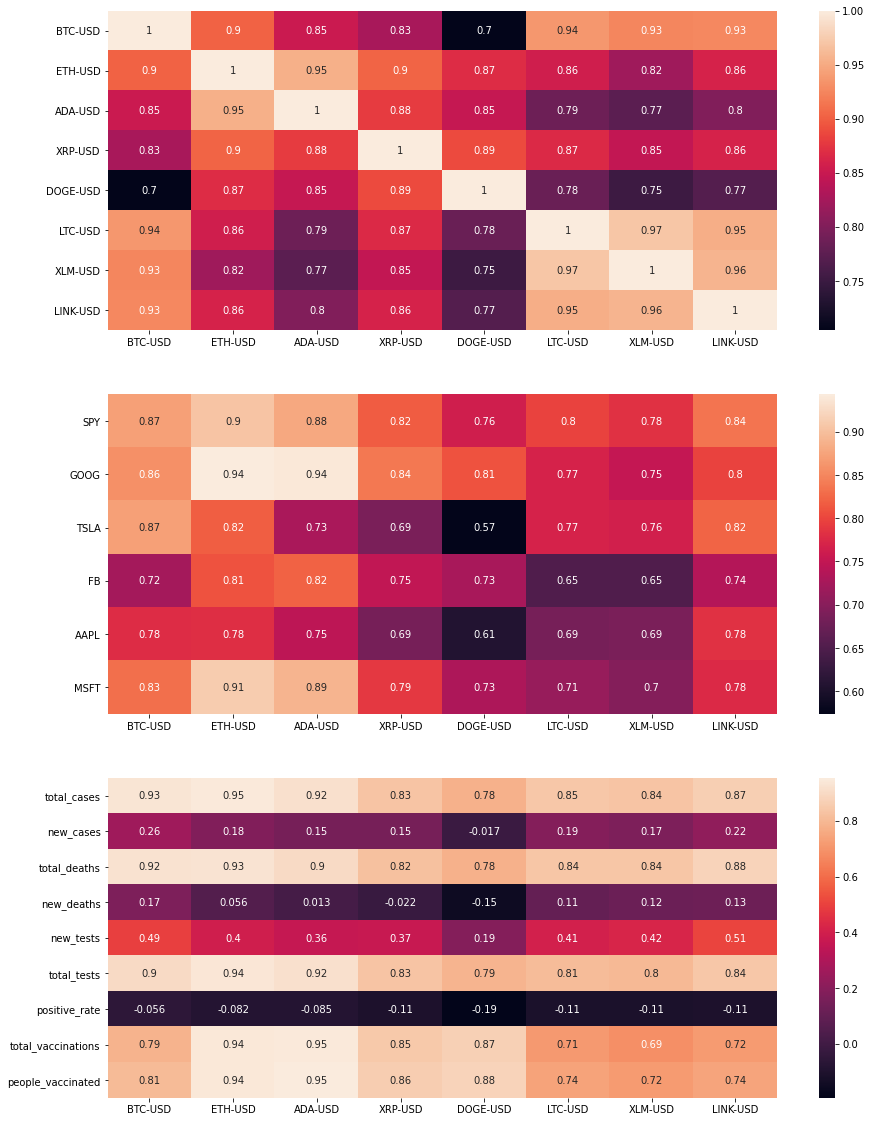

In [4]:
f,(ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(15, 20))
sns.heatmap(data[features[6:14]].corr(), annot=True, ax=ax1)
sns.heatmap(data[features[:14]].corr().iloc[:6, 6:], annot=True, ax=ax2)
sns.heatmap(data[features[6:]].corr().iloc[8:, :8], annot=True, ax=ax3)
plt.setp(ax2.get_yticklabels(), rotation=0)
plt.show()

In [5]:
data[features[6:]].fillna(method='ffill')[1:]

,BTC-USD,ETH-USD,ADA-USD,XRP-USD,DOGE-USD,LTC-USD,XLM-USD,LINK-USD,total_cases,new_cases,total_deaths,new_deaths,new_tests,total_tests,positive_rate,total_vaccinations,people_vaccinated
2020-01-23,8406.515625,162.928558,0.043334,0.226104,0.002268,54.630260,0.059238,2.462109,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
2020-01-24,8445.434570,163.051178,0.045004,0.223041,0.002276,54.531788,0.057303,2.504390,2.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
2020-01-25,8367.847656,161.283936,0.043248,0.220427,0.002257,53.697788,0.056039,2.456526,2.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
2020-01-26,8596.830078,168.077103,0.044581,0.230686,0.002305,56.212715,0.058572,2.571582,5.0,3.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
2020-01-27,8909.819336,170.930893,0.047912,0.231222,0.002368,58.763268,0.059645,2.609652,5.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-15,63557.871094,4557.503906,2.015587,1.171371,0.256529,262.763397,0.375941,32.010754,47222751.0,138787.0,764533.0,1271.0,314182.0,646690870.0,0.075,445740774.0,228562585.0
2021-11-16,60161.246094,4216.365234,1.877235,1.090934,0.237249,230.599426,0.344057,29.225008,47310337.0,87586.0,765811.0,1278.0,0.0,0.0,0.000,447107491.0,228974644.0
2021-11-17,60161.246094,4216.365234,1.877235,1.090934,0.237249,230.599426,0.344057,29.225008,47421741.0,111404.0,767433.0,1622.0,0.0,0.0,0.000,448043450.0,229255236.0
2021-11-18,60161.246094,4216.365234,1.877235,1.090934,0.237249,230.599426,0.344057,29.225008,47531319.0,109578.0,768695.0,1262.0,0.0,0.0,0.000,448155904.0,229291002.0


In [9]:
np.array(features[7:])

array(['ETH-USD', 'ADA-USD', 'XRP-USD', 'DOGE-USD', 'LTC-USD', 'XLM-USD',
       'LINK-USD', 'total_cases', 'new_cases', 'total_deaths',
       'new_deaths', 'new_tests', 'total_tests', 'positive_rate',
       'total_vaccinations', 'people_vaccinated'], dtype='<U18')

In [8]:
data = data.fillna(method='ffill')
raw_X = MinMaxScaler().fit_transform(data[features[7:]])[1:]
raw_y = data['BTC-USD'].pct_change()[1:].values.reshape(len(data)-1, 1)

raw_X.shape, raw_y.shape

((664, 16), (664, 1))

In [10]:
X = np.array([raw_X[i-90:i] for i in range(90, len(raw_X))])
y = raw_y[90:]

X.shape, y.shape

((574, 90, 16), (574, 1))

In [15]:
model = tf.keras.Sequential()
model.add(LSTM(units=32, return_sequences=True,
                  input_shape=(90, 16), dropout=0.2))
model.add(LSTM(units=32, dropout=0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 90, 32)            6272      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 14,625
Trainable params: 14,625
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X, y, epochs=1, batch_size=600, verbose=0)
pred = model.predict(X)

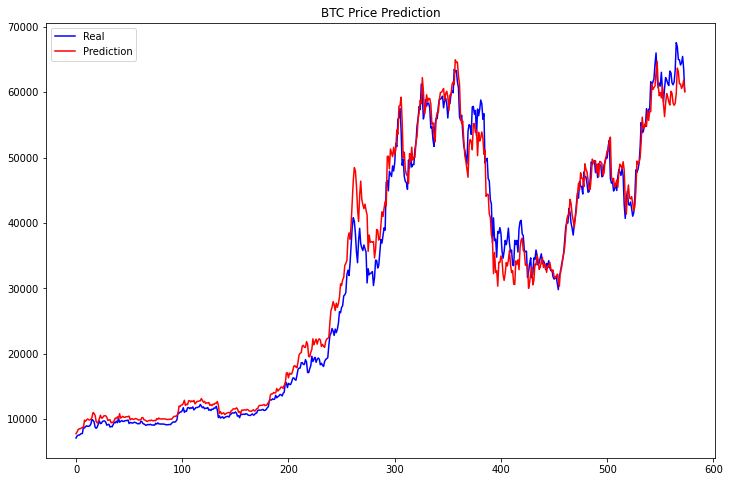

In [17]:
real_prices = [(1+y[i, 0]) * data['BTC-USD'][i+90] for i in range(0, len(pred))]
pred_prices = [(1+pred[i, 0]) * data['BTC-USD'][i+90] for i in range(0, len(pred))]

plt.figure(figsize=(12,8))
plt.plot(real_prices, color='blue', label='Real')
plt.plot(pred_prices, color='red', label='Prediction')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()

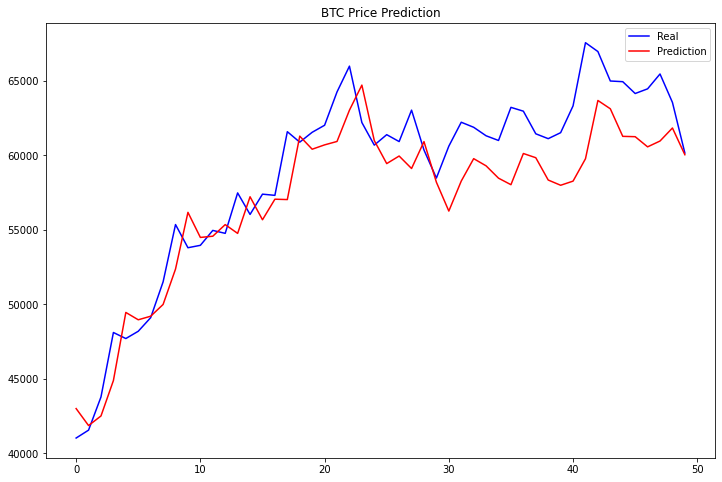

In [18]:
plt.figure(figsize=(12,8))
plt.plot(real_prices[-50:], color='blue', label='Real')
plt.plot(pred_prices[-50:], color='red', label='Prediction')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()